In [1]:
import pyautogui
import datetime
import pygetwindow as gw
import win32gui
import sys
import cv2
import os
import time
import numpy as np
sys.path.append('../')
from Segmentation_country.segmentation_country import segmentation_country_class, recognition_class
#from agents.simple_agent_matrix import simple_agent_matrix
from misiones import misiones
from tablero_jugador import Tablero
from Jugadores.jugador import Jugador
from Jugadores.jugadorGrafoOptimizado_2Cambios import JugadorGrafoOptimizado

import math
from matplotlib import pyplot as plt   

In [2]:
def calcular_diferencia_color(color1, color2):
    r1, g1, b1 = color1
    r2, g2, b2 = color2

    diferencia = math.sqrt((r2 - r1)**2 + (g2 - g1)**2 + (b2 - b1)**2)
    return diferencia

def identificar_color(color_a_identificar, color_referencia, umbral):
    diferencia = calcular_diferencia_color(color_a_identificar, color_referencia)
    if diferencia <= umbral:
        return True
    else:
        print(diferencia,umbral)
        return False

In [3]:
def get_chrome_printscreen(filename_save):
    # Nombre de la ventana de Google Chrome
    chrome_window_title = "Google Chrome"

    # Obtener todas las ventanas abiertas
    windows = gw.getAllTitles()

    # Buscar la ventana de Google Chrome en la lista de ventanas
    chrome_window = None
    for window_title in windows:
        if chrome_window_title in window_title:
            chrome_window = gw.getWindowsWithTitle(window_title)[0]
            break

    # Verificar si se encontró la ventana de Chrome
    if chrome_window is None:
        print('nenhuma janela chrome detectada')
        return False

    # Obtener el título de la ventana de Chrome
    chrome_title = win32gui.GetWindowText(chrome_window._hWnd)

    window_title = chrome_title

    # # Obtener la ventana por su título
    window = gw.getWindowsWithTitle(window_title)

    # # Verificar si se encontró la ventana
    if len(window) == 0:
        print(f"No se encontró una ventana con el título '{window_title}'.")

    else:
        # Seleccionar la primera ventana encontrada (puedes ajustar esto si hay varias)
        target_window = window[0]

        # Activar la ventana
        target_window.activate()

        # Capturar la ventana activa
        #
        screenshot = pyautogui.screenshot(region=[target_window.left, target_window.top, target_window.width, target_window.height])

        # Generar un nombre de archivo único basado en la fecha y hora
        timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        filename = f"screenshot_{timestamp}.png"

        # Guardar la captura de pantalla en un archivo
        screenshot.save(filename)

        print(f"Captura de pantalla de la ventana '{window_title}' guardada como {filename}")

        cv_image = cv2.imread(filename)

        crop_image = cv_image[200:900, 200:1300]
        # cv2.imshow("cropped", crop_image)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        cv2.imwrite(filename_save, crop_image)
        #os.remove(filename)
        return True

def get_player_color(image):

    try:
        player_color = ''
        a2D = image.reshape(-1,image.shape[-1])
        #remove a2D [0,0,0] items
        a2D = a2D[np.all(a2D >= [10,10,10], axis=1)] #removendo black pixels
        #removendo pixels brancos
        a2D = a2D[np.all(a2D<=[240,240,240], axis=1)]
        print('a2D pos remocao black pixels e pixels brancos shape: ', a2D.shape)
        col_range = (256, 256, 256) # generically : a2D.max(0)+1
        a1D = np.ravel_multi_index(a2D.T, col_range)
        bgr_format = np.unravel_index(np.bincount(a1D).argmax(), col_range)
        print('bgr_format: ', bgr_format)
        #colores = ["blue", "red", "green", "purple", "yellow", "black"]
        colores ={"red" : [49,34,185],
                "blue":[181,148,21],
                "green":[53,141,87],
                "yellow":[30,176,218],
                "purple":[116,46,76],
                "black":[56,56,56]} #BLUE GREEN RED
        
        player_color=None
        for key in colores:
            if (identificar_color(bgr_format, colores[key], 95)):
                player_color = key
                break
            else:
                player_color = "blue"
        #time_end = time.time()
        #print('time to get color: ', time_end - time_start)
    except Exception as e:
        player_color = "blue"
        print('error: ', e)
    finally:
        return player_color


def create_matrix_from_masks(masks, ocr: recognition_class):
    #cria matriz de adjacencia
    matrix = []
    territory_army_dict = {}
    for item,mask in masks.items():
        try:
            army = int(ocr.recog_image(mask))
        except:
            army = 1
        if(army is None):
            army = 1
        plyer_color = get_player_color(mask.copy())
        territory_army_dict[item] = [army,plyer_color]

        if (plyer_color is None):
            print('pais: {0} com {1} tropas e cor {2}'.format(item, army, plyer_color))
            cv2.imshow(item, mask)
            cv2.resizeWindow(item, 600,600)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
    
    return territory_army_dict

In [4]:
segmentation_prediction = segmentation_country_class("./DA_rodrigo_4000_mobilenetv2.h5")
ocr = recognition_class("text-recognition-resnet-fc-ft-v3-norm.xml","text-recognition-resnet-fc-ft-v3-norm.bin")
screenshot_filepath = "crop_screenshot_completo.jpg"
#CORES  = [  0   ,  1  ,   2   ,    3    ,  4     ,   5  ]
colores = ["blue","red","green","purple","yellow","black"]
#MISAON
cinza_objectivo = 0
Jugador_puc = JugadorGrafoOptimizado("JOGADOR_PUCPR_IA", colores[0], misiones[cinza_objectivo])

mision_desconocida = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]
jugador1 = Jugador("1",colores[1],mision_desconocida)
jugador2 = Jugador("2",colores[2],mision_desconocida)
jugador3 = Jugador("3",colores[3],mision_desconocida)
jugador4 = Jugador("4",colores[4],mision_desconocida)
jugador5 = Jugador("5",colores[5],mision_desconocida)

jugadores = [Jugador_puc,jugador1,jugador2,jugador3,jugador4,jugador5]
tablero = Tablero(jugadores)
Jugador_puc.interpretar_mision(misiones[cinza_objectivo])
Jugador_puc.descripcion = misiones[cinza_objectivo].descripcion

layer input shape:  [1,1,32,100]
_____ se ha establecido la mision de conquistar continentonces :  ['Europa', 'Oceanía']
Es neceseario tambien un continente extra : 
_____ se ha establecido la mision de conquistar continentonces :  ['Europa', 'Oceanía']
Es neceseario tambien un continente extra : 


In [5]:
masks = segmentation_prediction.predict_masks(screenshot_filepath)

1/1 [==============================] - 1s 1s/step


In [6]:
for item,mask in masks.items():
    print(item)

Alaska
Mackenzie
Groenlandia
Vancouver
Ottawa
Labrador
California
Nueva York
México
Venezuela
Perú
Brasil
Argentina
Islandia
Inglaterra
Francia
Alemania
Suecia
Polonia
Moscú
Omsk
Dudinka
Siberia
Vladivostok
Argelia
Egipto
Oriente Medio
Aral
Chita
Congo
Sudán
India
China
Mongolia
Sudáfrica
Madagascar
Vietnam
Japón
Sumatra
Borneo
Nueva Guinea
Australia


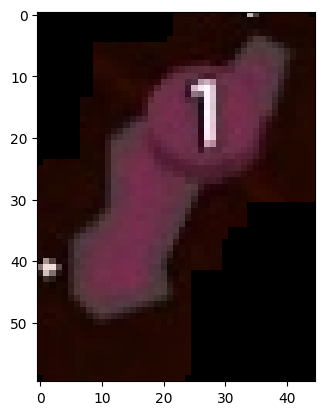

In [10]:
plt.imshow(masks['Madagascar'])

In [8]:
dic = create_matrix_from_masks(masks, ocr)

a2D pos remocao black pixels e pixels brancos shape:  (4199, 3)
bgr_format:  (48, 143, 86)
147.25148556126692 95
148.1181960462657 95
a2D pos remocao black pixels e pixels brancos shape:  (8912, 3)
bgr_format:  (116, 46, 76)
128.50680915811427 95
132.86835590162167 95
114.52074047961793 95
210.85540068966694 95
a2D pos remocao black pixels e pixels brancos shape:  (731, 3)
bgr_format:  (114, 47, 76)
127.57350822173073 95
133.09770847013107 95
112.59662517144997 95
209.43017929610812 95
a2D pos remocao black pixels e pixels brancos shape:  (7005, 3)
bgr_format:  (49, 34, 185)
a2D pos remocao black pixels e pixels brancos shape:  (1523, 3)
bgr_format:  (32, 177, 223)
148.93622796351463 95
252.67766027094677 95
142.24275025462634 95
a2D pos remocao black pixels e pixels brancos shape:  (2806, 3)
bgr_format:  (31, 176, 221)
147.59403781996073 95
251.56311335328954 95
140.23195071024293 95
a2D pos remocao black pixels e pixels brancos shape:  (7557, 3)
bgr_format:  (48, 143, 86)
147.2514855

In [9]:
tablero.actualizarFronDic(dic)
tablero.mostrar_tablero()

Nombre del país: Brasil
Continente: América del Sur
Propietario: 1
Tropas: 15
Vecinos: ['Argentina', 'Venezuela', 'Perú']
-----
Nombre del país: Argentina
Continente: América del Sur
Propietario: 2
Tropas: 9
Vecinos: ['Perú', 'Brasil']
-----
Nombre del país: Venezuela
Continente: América del Sur
Propietario: 1
Tropas: 1
Vecinos: ['Brasil', 'Perú', 'México']
-----
Nombre del país: Perú
Continente: América del Sur
Propietario: 1
Tropas: 8
Vecinos: ['Argentina', 'Brasil']
-----
Nombre del país: México
Continente: América del Norte
Propietario: 2
Tropas: 7
Vecinos: ['Venezuela', 'Nueva York', 'California']
-----
Nombre del país: Nueva York
Continente: América del Norte
Propietario: 3
Tropas: 19
Vecinos: ['México', 'California', 'Ottawa', 'Labrador']
-----
Nombre del país: California
Continente: América del Norte
Propietario: 2
Tropas: 3
Vecinos: ['México', 'Nueva York', 'Ottawa', 'Vancouver']
-----
Nombre del país: Ottawa
Continente: América del Norte
Propietario: 4
Tropas: 2
Vecinos: ['Nu